In [1]:
import logging
from math import ceil
from pathlib import Path
from typing import Callable, Iterable, Literal, Optional, TypeAlias
import warnings

import fastf1 as f
import fastf1.plotting as p
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import tomli
from matplotlib import pyplot as plt
from matplotlib import rcParams

Figure: TypeAlias = matplotlib.figure.Figure

logging.basicConfig(level=logging.INFO, format="%(levelname)s	%(filename)s	%(message)s")

In [2]:
parent_path = Path.cwd().parent

In [3]:
# plotting setup
sns.set(rc={"figure.dpi": 300, "savefig.dpi": 300})
plt.style.use("dark_background")

In [4]:
# Suppress pandas SettingWithCopy warning
pd.options.mode.chained_assignment = None

# Suppress Seaborn false positive warnings
warnings.filterwarnings("ignore")

In [5]:
# read configs
with open(parent_path / "Data" / "compound_selection.toml", "rb") as toml:
    compound_selection = tomli.load(toml)

with open(parent_path / "Data" / "visualization_config.toml", "rb") as toml:
    visual_config = tomli.load(toml)

visual_config["fresh"]["hatch"]["True"] = None

# Load Dataframes 

In [6]:
def correct_dtype(df_laps: pd.DataFrame) -> pd.DataFrame:
    """Fix incorrectly parsed data types.

    All timing data are cast to timedelta from string.
    `TrackStatus` is cast to string from int.
    `FreshTyre` has its missing values filled with UNKNOWN and then cast to string.

    Requires:
        df_laps has the following columns: [`Time`,
                                            `PitInTime`,
                                            `PitOutTime`,
                                            "TrackStatus`,
                                            `FreshTyre`]
    """
    # convert from object (string) to timedelta
    df_laps[["Time", "PitInTime", "PitOutTime"]] = df_laps[
        ["Time", "PitInTime", "PitOutTime"]
    ].apply(pd.to_timedelta)

    # TrackStatus column makes more sense as strings
    df_laps["TrackStatus"] = df_laps["TrackStatus"].astype(str)
    df_laps["TrackStatus"] = df_laps["TrackStatus"].apply(lambda x: x.rstrip(".0"))

    # Fill FreshTyre column NAs with "Unknown"
    # Then cast to string
    # This ensures rows with missing FreshTyre entry will still be plotted
    df_laps["FreshTyre"] = df_laps["FreshTyre"].fillna("Unknown")
    df_laps["FreshTyre"] = df_laps["FreshTyre"].astype(str)

    return df_laps

In [7]:
def load_laps() -> dict[int, pd.DataFrame]:
    """Load transformed data by season."""
    df_dict = {}

    for file in Path.iterdir(parent_path / "Data"):
        if file.suffix == ".csv":
            splits = file.stem.split("_")

            if splits[0] == "transformed":
                season = int(splits[2])
                df = pd.read_csv(
                    parent_path / "Data" / file,
                    header=0,
                    true_values=["True"],
                    false_values=["False"],
                )
                correct_dtype(df)
                df_dict[season] = df

    return df_dict

In [8]:
df_dict = load_laps()

# Visualization Functions

## Helper Functions

In [9]:
def find_legend_order(labels: Iterable[str]) -> list[int]:
    """Provide the index of a list of compounds sorted from soft to hard.

    Args:
        labels: A list of string representing the tyre compounds.

    Returns:
        A list of ints corresponding to the original index of the
        compound names if they were in sorted order (softest to hardest,
        slick compounds first).

    Examples:
        labels = ["MEDIUM", "HARD", "SOFT"]
        desired = ["SOFT", "MEDIUM", "HARD"]
        return [2, 0, 1]

        labels = ["C3", "C1", "WET"]
        desired = ["C1", "C3", "WET"],
        return [1, 0, 2]
    """
    order = []
    old_indices = list(range(len(labels)))
    sorted_labels = []

    if any(
        [
            name in labels
            for name in ["HYPERSOFT", "ULTRASOFT", "SUPERSOFT", "SUPERHARD"]
        ]
    ):
        # 2018 absolute compound names
        sorted_labels = visual_config["absolute"]["labels"]["18"]
    elif any([label.startswith("C") for label in labels]):
        # 19_22 absolute compound names
        sorted_labels = visual_config["absolute"]["labels"]["19_22"]
    else:
        # default to relative names
        sorted_labels = visual_config["relative"]["labels"]

    pos = [sorted_labels.index(label) for label in labels]
    order = [old_index for _, old_index in sorted(zip(pos, old_indices))]

    return order

In [10]:
def filter_round_driver(
    df_laps: pd.DataFrame, round_number: int, drivers: Iterable[str]
) -> pd.DataFrame:
    """Filter dataframe by round number and drivers.

    Round number requires exact match.

    Requires:
        df_laps has the following columns: [`RoundNumber`, `Driver`]
    """
    df_laps = df_laps[
        (df_laps["RoundNumber"] == round_number) & (df_laps["Driver"].isin(drivers))
    ]

    return df_laps


def filter_round_driver_upper(
    df_laps: pd.DataFrame,
    round_number: int,
    drivers: Iterable[str],
    upper_bound: int | float,
) -> pd.DataFrame:
    """
    Filter dataframe by round number, drivers, and lap time as a percentage
    of the fastest lap.

    Round number requires exact match.
    Upper bound is given as the percentage difference from the fastest lap.

    Requires:
        df_laps has the following columnds: [`RoundNumber`, `Driver`, `PctFromFastest`]
    """
    df_laps = df_laps[
        (df_laps["RoundNumber"] == round_number)
        & (df_laps["Driver"].isin(drivers))
        & (df_laps["PctFromFastest"] < upper_bound)
    ]

    return df_laps


def filter_round_compound_valid_upper(
    df_laps: pd.DataFrame,
    round_number: int,
    compounds: Iterable[str],
    upper_bound: int | float,
) -> pd.DataFrame:
    """Filter dataframe by round number, drivers, and lap time upper bound.

    Round number requires exact match.
    Upper bound is given as the percentage difference from the fastest lap.

    Requires:
        df_laps has the following columnds: [`RoundNumber`, `Driver`, `PctFromFastest`]
    """
    df_laps = df_laps[
        (df_laps["RoundNumber"] == round_number)
        & (df_laps["IsValid"])
        & (df_laps["Compound"].isin(compounds))
        & (df_laps["PctFromFastest"] < upper_bound)
    ]

    return df_laps

In [11]:
def plot_args(season: int, absolute_compound: bool) -> tuple:
    """Get plotting arguments based on the season and compound type.

    Args:
        season: Championship season

        absolute_compound: If true, use absolute compound names
                           (C1, C2 ...) in legend
                           Else, use relative compound names
                           (SOFT, MEDIUM, HARD) in legend

    Returns:
        (hue, palette, marker, labels)
    """
    if absolute_compound:
        if season == 2018:
            return (
                "CompoundName",
                visual_config["absolute"]["palette"]["18"],
                visual_config["absolute"]["markers"]["18"],
                visual_config["absolute"]["labels"]["18"],
            )
        else:
            return (
                "CompoundName",
                visual_config["absolute"]["palette"]["19_22"],
                visual_config["absolute"]["markers"]["19_22"],
                visual_config["absolute"]["labels"]["19_22"],
            )
    else:
        return (
            "Compound",
            visual_config["relative"]["palette"],
            visual_config["relative"]["markers"],
            visual_config["relative"]["labels"],
        )

In [12]:
def get_drivers(
    session: f.core.Session,
    drivers: Iterable[str | int] | str | int,
    by: str = "Position",
) -> list[str]:
    """Find driver three-letter abbreviations.

    Assumes:
        session.results is sorted by finishing position

    Args:
        session: The race session object, relevant for determining finishing order.

        drivers: The following argument formats are accepted:
            - A single integer retrieve the highest ordered drivers
              e.g. drivers = 10 with by = "Position" will fetch the point finishiers

              drivers = 20 will return all available drivers
            - A string representing either the driver's three letter abbreviation
              or driver number.
              e.g. "VER" or "44"
            - A list of integers and/or strings representing either the driver's
              three letter abbreviation or driver number.
              e.g. ["VER", "44", 14]

        by: The key by which the drivers are sorted. Default is sorting by finishing position.
            See all available options in FastF1 `Session.results` documentation.

    Returns:
        The drivers' three-letter abbreviations, in the order requested.
        (Or in the case of int argument, in the finishing order.)
    """
    if isinstance(drivers, int):
        result = session.results.sort_values(by=by, kind="stable")
        drivers = result["Abbreviation"].unique()[:drivers]
        return list(drivers)
    elif isinstance(drivers, str):
        drivers = [drivers]

    ret = []
    for driver in drivers:
        if isinstance(driver, (int, float)):
            driver = str(int(driver))
        ret.append(session.get_driver(driver)["Abbreviation"])

    return ret


def get_session_info(
    season: int,
    event: int | str,
    drivers: Iterable[str | int] | str | int = 3,
    teammate_comp: bool = False,
) -> tuple[int, str, list[str]]:
    """Retrieve session information based on season and event number / name.

    If event is provided as a string, then the name fuzzy matching is done by Fastf1.

    If teammate_comp is True, then the drivers are returned in the order of increasing team
    names (higher finishing teammate first) instead of by finishing position.
    """
    session = f.get_session(season, event, "R")
    session.load(laps=False, telemetry=False, weather=False, messages=False)
    round_number = session.event["RoundNumber"]
    event_name = session.event["EventName"]

    if teammate_comp:
        drivers = get_drivers(session, drivers, by="TeamName")
    else:
        drivers = get_drivers(session, drivers)

    return round_number, event_name, drivers

In [13]:
def pick_driver_color(driver: str) -> str:
    """Find the driver's color.

    If the driver is currently active, use his FastF1 color.
    Else, default to gray.
    """
    if p.DRIVER_TRANSLATE.get(driver, "NA") in p.DRIVER_COLORS:
        return p.DRIVER_COLORS[p.DRIVER_TRANSLATE[driver]]
    else:
        return "#808080"

In [14]:
def add_gap(season: int, driver: str) -> pd.DataFrame:
    """Calculate the gap to a certain driver for all laps in a season."""
    df_laps = df_dict[season]
    assert driver.upper() in df_laps["Driver"].unique()
    df_driver = df_laps[df_laps["Driver"] == driver]

    # start a memo
    driver_laptimes = {i: {} for i in df_driver["RoundNumber"].unique()}

    def calculate_gap(row, driver):
        round = row.loc["RoundNumber"]
        lap = row.loc["LapNumber"]

        if lap not in driver_laptimes[round]:
            laptime = df_driver[
                (df_driver["RoundNumber"] == round) & (df_driver["LapNumber"] == lap)
            ]["Time"]

            if laptime.empty:
                driver_laptimes[round][lap] = pd.NaT
            else:
                driver_laptimes[round][lap] = laptime.iloc[0]

        return (row.loc["Time"] - driver_laptimes[round][lap]).total_seconds()

    df_laps[f"GapTo{driver}"] = df_laps.apply(
        lambda row: calculate_gap(row, driver), axis=1
    )
    df_dict[season] = df_laps

    return df_laps

In [15]:
def lap_filter_sc(row: pd.Series) -> bool:
    """Check if any part of a lap is ran under safety car.

    Track status 4 stands for safety car.

    Caveats:
        Might overcount, unsure if the lap after "safety car in this lap will be included.
    """
    return "4" in row.loc["TrackStatus"]


def lap_filter_vsc(row: pd.Series) -> bool:
    """Check if any part of a lap is ran under virtual safety car.

    Track status 6 is VSC deployed.
    Track status 7 is VSC ending.

    Caveats:
        Might double count with the `lap_filter_sc` function.
    """
    return ("6" in row.loc["TrackStatus"]) or ("7" in row.loc["TrackStatus"])


def find_sc_laps(
    df_laps: np.ndarray, vsc: bool = False
) -> tuple[np.ndarray, np.ndarray]:
    """Shade SC or VSC periods lasting at least one lap on the current figure.

    Args:
        sc_laps: Sorted array of integers indicating laps under SC or VSC.

        vsc: Toggle VSC hatches and label.
    """
    sc_laps = np.sort(
        df_laps[df_laps.apply(lap_filter_sc, axis=1)]["LapNumber"].unique()
    )
    vsc_laps = np.sort(
        df_laps[df_laps.apply(lap_filter_vsc, axis=1)]["LapNumber"].unique()
    )

    return sc_laps, vsc_laps


def shade_sc_periods(sc_laps, vsc=False):
    """
    Shade SC periods lasting at least one lap on the current figure

    Args:
        sc_laps: array-like
            Array of integers indicating laps under SC or VSC
    """

    sc_laps_copy = np.append(sc_laps, [-1])

    start = 0
    end = 1

    while end < len(sc_laps_copy):
        # check if two SC laps are continuous
        if sc_laps_copy[end] == sc_laps_copy[end - 1] + 1:
            end += 1
        else:
            # current SC period has ended
            # if the period is at least one full lap
            if end - start > 1:
                # minus one to correct for zero indexing on the plot
                # but one indexing in the data
                plt.axvspan(
                    xmin=sc_laps_copy[start] - 1,
                    xmax=sc_laps_copy[end - 1] - 1,
                    alpha=0.5,
                    color="orange",
                    hatch="-" if vsc else None,
                    label="VSC" if vsc else "SC",
                )

            start = end
            end += 1

    return None

In [16]:
def convert_compound_names(
    season: int, round_number: int, compounds: Iterable[str]
) -> tuple[str]:
    """Convert relative compound names to absolute compound names.

    Args:
        season: Championship season

        round_number: Grand Prix round number.

        compounds: Relative compound names to convert.

    Examples:
        2023 round 1 selects C1, C2, C3 compounds.

        Then convert_compound_names(
        2023, 1, ["SOFT", "HARD"]
        ) = ["C1", "C3"]
    """
    compound_to_index = {"SOFT": 2, "MEDIUM": 1, "HARD": 0}
    if season == 2018:
        compound_to_index = {"SOFT": 0, "MEDIUM": 1, "HARD": 2}

    return_vals = []

    for compound in compounds:
        return_vals.append(
            compound_selection[str(season)][str(round_number)][
                compound_to_index[compound]
            ]
        )

    return tuple(return_vals)


def process_input(
    seasons: Iterable[int],
    events: Iterable[str | int],
    y: str,
    compounds: Iterable[str],
    x: str,
    upper_bound: int | float,
    absolute_compound: bool,
) -> tuple[list[f.events.Event], list[pd.DataFrame]]:
    """Sanitize input parameters to compound plots.

    Returns:
        event_objects: List of event objects corresponding to each requested race

        included_laps_lst: List of dataframes corresponding to each requested race
    """
    # unpack
    compounds = [compound.upper() for compound in compounds]

    for compound in compounds:
        assert compound in [
            "SOFT",
            "MEDIUM",
            "HARD",
        ], f"requested compound {compound} is not valid"

    if x != "LapNumber" and x != "TyreLife":
        logging.warning(
            (
                f"Using {x} as the x-axis is not recommended."
                " The recommended arguments are LapNumber and TyreLife"
            )
        )

    assert (
        seasons and events and len(seasons) == len(events)
    ), f"num seasons ({len(seasons)}) does not match num events ({len(events)})"

    if not absolute_compound and len(events) > 1:
        logging.warning(
            """
            Different events may use different compounds under the same name!
            e.g. SOFT may be any of C3 to C5 dependinging on the event
            """
        )

    # Combine seasons and events and get FastF1 event objects
    event_objects = [f.get_event(seasons[i], events[i]) for i in range(len(seasons))]
    included_laps_lst = []

    for season, event in zip(seasons, event_objects):
        df_laps = filter_round_compound_valid_upper(
            df_dict[season], event["RoundNumber"], compounds, upper_bound
        )

        # LapRep columns have outliers that can skew the graph y-axis
        # The high outlier values are filtered by upper_bound
        # Using a lower bound of -5 on PctFromLapRep will retain 95+% of all laps
        if y == "PctFromLapRep" or y == "DeltaToLapRep":
            df_laps = df_laps[df_laps["PctFromLapRep"] > -5]

        included_laps_lst.append(df_laps)

    return event_objects, included_laps_lst

## Tyre Usage

In [17]:
def make_autopct(values: pd.DataFrame | pd.Series) -> Callable:
    """Format group sizes as percentages of the total."""

    def my_autopct(pct):
        total = sum(values)

        # additional call to int is for type conversion
        # not duplicated rounding
        val = int(round(pct * total / 100.0))
        return "{p:.1f}%  ({v:d})".format(p=pct, v=val)

    return my_autopct


def get_pie_palette(season: int, absolute: bool, labels: Iterable[str]) -> list[str]:
    """Get the tyre compound palette needed for the pie chart."""
    if absolute:
        if season == 2018:
            return [
                visual_config["absolute"]["palette"]["18"][label] for label in labels
            ]
        else:
            return [
                visual_config["absolute"]["palette"]["19_22"][label] for label in labels
            ]
    else:
        return [visual_config["relative"]["palette"][label] for label in labels]


def make_pie_title(season: int, slick_only: bool) -> str:
    """Compose the pie chart title."""
    if slick_only:
        return f"Slick Compound Usage in the {season} Season"
    else:
        return f"All Compound Usage in the {season} Season"

In [18]:
def tyre_usage_pie(
    season: int,
    title: Optional[str] = None,
    events: Optional[list[int | str]] = None,
    drivers: Optional[list[str]] = None,
    slick_only: bool = True,
    absolute_compound: bool = True,
) -> Figure:
    """Visualize tyre usage trends by compound with a pie chart.

    The arguments configure the range of data from which
    the tyre usage frequency is calculated.

    Args:
        season: Championship season

        title: Use default argument to use an automatically formatted title.
        Only available when events and drivers are None.

        events: A list containing the round numbers (as int) or the names of events.
        Examples: [1, "Hungary", "British Grand Prix", "Monza"]
        Name fuzzy matched by fastf1.get_event().
        Leave empty will select all events in the season.

        drivers: A list containing three-letter driver abbreviations.
        Examples: ["VER", "HAM"]
        Leave empty to select all drivers.

        slick_only: If true, only laps raced on slick tyres are counted.
        If false, all laps are counted.

        absolute_compound: If true, group tyres by absolute compound names (C1, C2 etc.).
        Else, group tyres by relative compound names (SOFT, MEDIUM, HARD).

    Examples:
        Using the following arguments:
            events = [1, 2, 3, 4, 5]
            drivers = ["VER", "HAM"]
            slick_only = True
        Will plot the tyre compounds used by Hamilton and Verstappan
        in the first 5 Grand Prix only.
    """
    included_laps = df_dict[season]

    if title is None and events is None and drivers is None:
        title = make_pie_title(season, slick_only)

    if events is None:
        events = pd.unique(included_laps["RoundNumber"])
    else:
        events = [
            f.get_event(season, event)["RoundNumber"]
            if isinstance(event, str)
            else event
            for event in events
        ]

    if drivers is None:
        drivers = pd.unique(included_laps["Driver"])

    if slick_only:
        included_laps = included_laps[included_laps["IsSlick"] == True]

    included_laps = included_laps[
        (included_laps["RoundNumber"].isin(events))
        & (included_laps["Driver"].isin(drivers))
    ]

    fig, ax = plt.subplots(figsize=(10, 6))
    plt.style.use("default")

    lap_counts = None
    if absolute_compound:
        lap_counts = included_laps.groupby("CompoundName").size()
    else:
        lap_counts = included_laps.groupby("Compound").size()

    labels = lap_counts.index
    palette = get_pie_palette(season, absolute_compound, labels)

    wedges, texts, autotexts = ax.pie(
        x=lap_counts.values,
        labels=labels,
        colors=palette,
        autopct=make_autopct(lap_counts),
        counterclock=False,
        startangle=90,
    )

    handles, labels = ax.get_legend_handles_labels()
    label_order = find_legend_order(labels)
    ax.legend(
        handles=[handles[i] for i in label_order],
        labels=[labels[i] for i in label_order],
        title="Compound Names",
        loc="best",
    )

    ax.axis("equal")
    ax.set_title(title)
    plt.setp(autotexts, size=12)

    return fig

## Driver Stats Scatterplot

In [19]:
def driver_stats_scatterplot(
    season: int,
    event: int | str,
    drivers: Iterable[str | int] | str | int = 3,
    y: str = "LapTime",
    upper_bound: int | float = 10,
    absolute_compound: bool = False,
) -> Figure:
    """Visualize driver data during a race as a scatterplot.

    Args:
        season: Championship season

        event: Round number or name of the event.
        Name is fuzzy matched by fastf1.get_event().

        drivers: See `get_drivers` for all accepted formats.
        By default, the podium finishers are plotted.

        y: Name of the column to be used as the y-axis.

        upper_bound: The upper bound on included laps as a percentage of the fastest lap.
        By default, only laps that are less than 10% slower than the fastest lap are plotted.

        absolute_compound: If true, group tyres by absolute compound names (C1, C2 etc.).
        Else, group tyres by relative compound names (SOFT, MEDIUM, HARD).
    """
    plt.style.use("dark_background")
    fontdict = {
        "fontsize": rcParams["axes.titlesize"],
        "fontweight": rcParams["axes.titleweight"],
        "color": rcParams["axes.titlecolor"],
        "verticalalignment": "baseline",
        "horizontalalignment": "center",
    }

    round_number, event_name, drivers = get_session_info(season, event, drivers)
    included_laps = df_dict[season]
    included_laps = filter_round_driver(included_laps, round_number, drivers)

    max_width = 5
    num_row = ceil(len(drivers) / max_width)
    num_col = len(drivers) if len(drivers) < max_width else max_width
    fig, axes = plt.subplots(
        nrows=num_row,
        ncols=num_col,
        sharey=True,
        sharex=True,
        figsize=(5 * num_col, 5 * num_row),
    )
    args = plot_args(season, absolute_compound)

    # Prevent TypeError when only one driver is plotted
    if len(drivers) == 1:
        axes = np.array([axes])

    # LapRep columns have outliers that can skew the graph y-axis
    # The high outlier values are filtered by upper_bound
    # Using a lower bound of -5 on PctFromLapRep will retain 95+% of all laps
    if y == "PctFromLapRep" or y == "DeltaToLapRep":
        included_laps = included_laps[included_laps["PctFromLapRep"] > -5]

    for index, driver in enumerate(drivers):
        row = index // max_width
        col = index % max_width

        ax = axes[row][col] if num_row > 1 else axes[col]

        driver_laps = included_laps[included_laps["Driver"] == driver]
        pit_in_laps = driver_laps[driver_laps["PitInTime"].notnull()][
            "LapNumber"
        ].to_numpy()

        # After pitstops are identified, we can filter out laps that doesn't meet the upper_bound
        driver_laps = driver_laps[driver_laps["PctFromFastest"] < upper_bound]

        if driver_laps.shape[0] < 5:
            logging.warning(f"{driver} HAS LESS THAN 5 LAPS ON RECORD FOR THIS EVENT")

        sns.scatterplot(
            data=driver_laps,
            x="LapNumber",
            y=y,
            ax=ax,
            hue=args[0],
            palette=args[1],
            hue_order=args[3],
            style="FreshTyre",
            style_order=["True", "False", "Unknown"],
            markers=visual_config["fresh"]["markers"],
            legend="auto" if index == num_col - 1 else False,
        )

        ax.vlines(
            ymin=plt.yticks()[0][1],
            ymax=plt.yticks()[0][-2],
            x=pit_in_laps,
            label="Pitstop",
            linestyle="dashed",
        )

        driver_color = pick_driver_color(driver)
        fontdict["color"] = driver_color
        ax.set_title(label=driver, fontdict=fontdict, fontsize=12)

        ax.grid(color=driver_color, which="both", axis="both")
        sns.despine(left=True, bottom=True)

    fig.suptitle(t=f"{season} {event_name}", fontsize=20)
    axes.flatten()[num_col - 1].legend(loc="best", fontsize=8, framealpha=0.5)

    return fig

## Driver Stats Lineplot

In [20]:
def driver_stats_lineplot(
    season: int,
    event: int | str,
    drivers: Iterable[str | int] | str | int = 20,
    y: str = "Position",
    upper_bound: int | float = 10,
    grid: Optional[Literal["both", "x", "y"]] = None,
) -> Figure:
    """Visualize driver data during a race as a lineplot.

    Args:
        season: Championship season

        event: Round number or name of the event.
        Name is fuzzy matched by fastf1.get_event().

        drivers: See `get_drivers` for all accepted formats.
        By default, all drivers are plotted.

        y: Name of the column to be used as the y-axis.

        upper_bound: The upper bound on included laps as a percentage of the fastest lap.
        By default, only laps that are less than 10% slower than the fastest lap are plotted.

        grid: Provided to plt.grid() axis argument.
        Leave empty to plot no grid.
    """
    plt.style.use("dark_background")

    round_number, event_name, drivers = get_session_info(season, event, drivers)
    included_laps = df_dict[season]
    included_laps = filter_round_driver(included_laps, round_number, drivers)

    # find safety car (both SC and VSC) periods
    # only safety car lasting at least one full lap will be shown
    # if a lap falls under both category, SC takes precedence
    sc_laps, vsc_laps = find_sc_laps(included_laps)
    vsc_laps = [lap for lap in vsc_laps if lap not in sc_laps]

    # do upper bound filtering after SC periods are identified
    included_laps = filter_round_driver_upper(
        included_laps, round_number, drivers, upper_bound
    )

    # adjust plot size based on number of laps
    num_laps = included_laps["LapNumber"].nunique()
    fig, ax = plt.subplots(figsize=(ceil(num_laps * 0.25), 8))

    if y == "Position" or y.startswith("GapTo"):
        ax.invert_yaxis()

    if y == "Position":
        plt.yticks(range(2, 21, 2))

    if len(drivers) > 10:
        ax.grid(which="major", axis="x")
    else:
        ax.grid(which="major", axis="both")

    for driver in drivers:
        driver_laps = included_laps[included_laps["Driver"] == driver]
        driver_color = pick_driver_color(driver)

        sns.lineplot(
            driver_laps, x="LapNumber", y=y, ax=ax, color=driver_color, errorbar=None
        )
        last_lap = driver_laps["LapNumber"].max()
        last_pos = driver_laps[y][driver_laps["LapNumber"] == last_lap].iloc[0]

        ax.annotate(
            xy=(last_lap + 1, last_pos + 0.25),
            text=driver,
            color=driver_color,
            fontsize=12,
        )
        sns.despine(left=True, bottom=True)

    # shade SC periods
    shade_sc_periods(sc_laps)
    shade_sc_periods(vsc_laps, vsc=True)

    if grid in ["both", "x", "y"]:
        plt.grid(axis=grid)
    else:
        plt.grid(visible=False)

    plt.legend(loc="lower right", fontsize=10)

    fig.suptitle(t=f"{season} {event_name}", fontsize=20)

    return fig

## Driver Stats Distribution Plot


In [21]:
def driver_stats_distplot(
    season: int,
    event: int | str,
    drivers: Iterable[str | int] | str | int = 10,
    y: str = "LapTime",
    upper_bound: float | int = 10,
    swarm: bool = True,
    violin: bool = True,
    absolute_compound: bool = False,
    teammate_comp: bool = False,
) -> Figure:
    """Visualize race data distribution as a violinplot or boxplot + optional swarmplot.

    Args:
        season: Championship season

        event: Round number or name of the event.
        Name is fuzzy matched by fastf1.get_event().

        drivers: See `get_drivers` for all accepted formats.
        By default, the point finishers are plotted.

        y: Name of the column to be used as the y-axis.

        upper_bound: The upper bound on included laps as a percentage of the fastest lap.
        By default, only laps that are less than 10% slower than the fastest lap are plotted.

        swarm: Toggle swarmplot visibility.

        violin: Toggles between violinplot and boxplot.

        absolute_compound: If true, group tyres by absolute compound names (C1, C2 etc.).
        Else, group tyres by relative compound names (SOFT, MEDIUM, HARD).

        teammate_comp: If true, teammates are plotted next to each other with higher finishing teammate
        to the left. Otherwise, the drivers are plotted by finishing order (higher finishing to the left).
    """
    plt.style.use("dark_background")

    round_number, event_name, drivers = get_session_info(
        season, event, drivers, teammate_comp
    )

    included_laps = df_dict[season]
    included_laps = filter_round_driver_upper(
        included_laps, round_number, drivers, upper_bound
    )

    # Adjust plot size based on number of drivers plotted
    fig, ax = plt.subplots(figsize=(len(drivers) * 1.5, 8))
    args = plot_args(season, absolute_compound)

    driver_colors = [pick_driver_color(driver) for driver in drivers]

    if violin:
        sns.violinplot(
            data=included_laps,
            x="Driver",
            y=y,
            inner=None,
            scale="area",
            palette=driver_colors,
            order=drivers,
        )
    else:
        sns.boxplot(
            data=included_laps,
            x="Driver",
            y=y,
            palette=driver_colors,
            order=drivers,
            whiskerprops=dict(color="white"),
            boxprops=dict(edgecolor="white"),
            medianprops=dict(color="white"),
            capprops=dict(color="white"),
            showfliers=False,
        )

    if swarm:
        sns.swarmplot(
            data=included_laps,
            x="Driver",
            y=y,
            hue=args[0],
            palette=args[1],
            linewidth=0,
            size=5,
        )

        handles, labels = ax.get_legend_handles_labels()
        order = find_legend_order(labels)
        ax.legend(
            handles=[handles[idx] for idx in order],
            labels=[labels[idx] for idx in order],
            loc="best",
            title=args[0],
            frameon=True,
            fontsize=10,
            framealpha=0.5,
        )

    ax.grid(visible=False)

    fig.suptitle(t=f"{season} {event_name}", fontsize=20)

    return fig

## Tyre Strategy Barplot

In [22]:
def strategy_barplot(
    season: int,
    event: int | str,
    drivers: Iterable[str | int] | str | int = 20,
    absolute_compound: bool = False,
) -> Figure:
    """Visualize tyre strategies as a horizontal barplot.

    Args:
        season: Championship season

        event: Round number or name of the event.
        Name is fuzzy matched by fastf1.get_event().

        drivers: See `get_drivers` for all accepted formats.
        By default, all drivers are plotted.

        absolute_compound: If true, group tyres by absolute compound names (C1, C2 etc.).
        Else, group tyres by relative compound names (SOFT, MEDIUM, HARD).
    """
    round_number, event_name, drivers = get_session_info(season, event, drivers)
    included_laps = df_dict[season]
    included_laps = filter_round_driver(included_laps, round_number, drivers)

    fig, ax = plt.subplots(figsize=(5, len(drivers) // 3 + 1))
    plt.style.use("dark_background")

    driver_stints = (
        included_laps[
            ["Driver", "Stint", "Compound", "CompoundName", "FreshTyre", "LapNumber"]
        ]
        .groupby(["Driver", "Stint", "Compound", "CompoundName", "FreshTyre"])
        .count()
        .reset_index()
    )
    driver_stints = driver_stints.rename(columns={"LapNumber": "StintLength"})
    driver_stints = driver_stints.sort_values(by=["Stint"])

    args = plot_args(season, absolute_compound)

    for driver in drivers:
        stints = driver_stints.loc[driver_stints["Driver"] == driver]

        previous_stint_end = 0
        for idx, stint in stints.iterrows():
            plt.barh(
                [driver],
                stint["StintLength"],
                left=previous_stint_end,
                color=args[1][stint[args[0]]],
                edgecolor="black",
                fill=True,
                hatch=visual_config["fresh"]["hatch"][stint["FreshTyre"]],
            )

            previous_stint_end += stint["StintLength"]

    # shade safety car (both SC and VSC) periods
    # only safety car lasting at least one full lap will be shown
    # if a lap falls under both category, SC takes precedence
    sc_laps, vsc_laps = find_sc_laps(included_laps)
    vsc_laps = [lap for lap in vsc_laps if lap not in sc_laps]

    shade_sc_periods(sc_laps)
    shade_sc_periods(vsc_laps, vsc=True)

    plt.title(f"{season} {event_name}", fontsize=16)
    plt.xlabel("Lap Number")
    plt.grid(False)

    handles, labels = ax.get_legend_handles_labels()
    if labels:
        deduplicate_labels_handles = dict(zip(labels, handles))
        plt.legend(
            handles=deduplicate_labels_handles.values(),
            labels=deduplicate_labels_handles.keys(),
            loc="lower right",
            fontsize=10,
        )

    # Invert y-axis
    ax.invert_yaxis()

    # Remove frame from plot
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    return fig

### Compound Head-to-Head Line Chart

In [23]:
def compounds_lineplot(
    seasons: Iterable[int],
    events: Iterable[int | str],
    y: str = "LapTime",
    compounds: Iterable[str] = ["SOFT", "MEDIUM", "HARD"],
    x: str = "TyreLife",
    upper_bound: int | float = 10,
    absolute_compound: bool = True,
) -> Figure:
    """Visualize compound performances as a lineplot.

    Caveats:
        Only laps with `IsValid=True` are considered

    Args:
        seasons: Championship seasons of the events

        events: A mix of round numbers or names of the events
        Name is fuzzy matched by fastf1.get_event()

        Each (season, event) pair should uniquely identify an event.

        y: The column to use as the y-axis.

        compounds: The compounds to plot.

        x: The column to use as the x-axis.
        `TyreLife` or `LapNumber` recommended.

        upper_bound: The upper bound on included laps as a percentage of the fastest lap.
        By default, only laps that are less than 10% slower than the fastest lap are plotted.

        absolute_compound: If true, group tyres by absolute compound names (C1, C2 etc.).
        Else, group tyres by relative compound names (SOFT, MEDIUM, HARD).
    """
    plt.style.use("dark_background")

    event_objects, included_laps_lst = process_input(
        seasons, events, y, compounds, x, upper_bound, absolute_compound
    )

    fig, axes = plt.subplots(
        nrows=len(event_objects),
        sharex=True,
        ncols=1,
        figsize=(5, 5 * len(event_objects)),
    )

    # Prevent TypeError when only one event is plotted
    if len(events) == 1:
        axes = [axes]

    # Copy compounds values
    # May need to convert from relative to absolute names when plotting
    compounds_copy = compounds.copy()

    for i in range(len(event_objects)):
        args = plot_args(seasons[i], absolute_compound)
        included_laps = included_laps_lst[i]
        medians = included_laps.groupby([args[0], x])[y].median()

        round_number = event_objects[i]["RoundNumber"]
        event_name = event_objects[i]["EventName"]

        if absolute_compound:
            compounds_copy = convert_compound_names(seasons[i], round_number, compounds)

        for compound in compounds_copy:
            if compound in medians.index:
                ax = sns.lineplot(
                    x=medians.loc[compound].index,
                    y=medians.loc[compound].values,
                    ax=axes[i],
                    color=args[1][compound],
                    marker=args[2][compound],
                    markersize=4,
                    label=compound,
                )
            else:
                logging.warning(
                    (
                        f"{compounds[i]} is not plotted for {seasons[i]} {event_name}"
                        " because there is not enough data"
                    )
                )

        ax.set_ylabel(y, fontsize=12)

        handles, labels = axes[i].get_legend_handles_labels()
        order = find_legend_order(labels)
        axes[i].legend(
            handles=[handles[idx] for idx in order],
            labels=[labels[idx] for idx in order],
            loc="best",
            title=args[0],
            frameon=True,
            fontsize=10,
            framealpha=0.5,
        )

        ax.set_title(label=f"{seasons[i]} {event_name}", fontsize=12)
        ax.grid(which="both", axis="y")
        sns.despine(left=True, bottom=True)

    # reorder compound names for title
    compounds = [compounds[i] for i in find_legend_order(compounds)]

    fig.suptitle(t=" VS ".join(compounds), fontsize=14)

    return fig

### Compound Head-to-Head Distribution

In [24]:
def compounds_distribution(
    seasons: Iterable[int],
    events: Iterable[int | str],
    y: str = "LapTime",
    compounds: Iterable[str] = ["SOFT", "MEDIUM", "HARD"],
    violin_plot: bool = False,
    x: str = "TyreLife",
    upper_bound: int | float = 10,
    absolute_compound: bool = True,
) -> Figure:
    """Visualize compound performance as a boxplot or violinplot.

    Caveats:
        Only laps with `IsValid=True` are considered

    Args:
        seasons: Championship seasons of the events

        events: A mix of round numbers or names of the events
        Name is fuzzy matched by fastf1.get_event()

        Each (season, event) pair should uniquely identify an event.

        y: The column to use as the y-axis.

        compounds: The compounds to plot.

        violin_plot: Toggles violinplot and boxplot.

        x: The column to use as the x-axis.
        `TyreLife` or `LapNumber` recommended.

        upper_bound: The upper bound on included laps as a percentage of the fastest lap.
        By default, only laps that are less than 10% slower than the fastest lap are plotted.

        absolute_compound: If true, group tyres by absolute compound names (C1, C2 etc.).
        Else, group tyres by relative compound names (SOFT, MEDIUM, HARD).
    """
    plt.style.use("dark_background")

    event_objects, included_laps_lst = process_input(
        seasons, events, y, compounds, x, upper_bound, absolute_compound
    )

    # adjust plot size based on the chosen x-axis
    x_ticks = max([laps[x].nunique() for laps in included_laps_lst])
    fig, axes = plt.subplots(
        nrows=len(event_objects),
        sharex=True,
        ncols=1,
        figsize=(ceil(x_ticks * 0.75), 5 * len(event_objects)),
    )

    # Prevent TypeError when only one event is plotted
    if len(events) == 1:
        axes = [axes]

    # Copy compounds values
    # May need to convert from relative to absolute names when plotting
    compounds_copy = compounds.copy()

    for i in range(len(event_objects)):
        args = plot_args(seasons[i], absolute_compound)
        included_laps = included_laps_lst[i]

        plotted_compounds = included_laps["Compound"].unique()
        event_name = event_objects[i]["EventName"]
        round_number = event_objects[i]["RoundNumber"]

        if absolute_compound:
            compounds_copy = convert_compound_names(seasons[i], round_number, compounds)

        for compound in compounds_copy:
            if compound not in plotted_compounds:
                logging.warning(
                    (
                        f"{compound} is not plotted for {seasons[i]} {event_name}"
                        " because there is no valid lap time data"
                    )
                )

        if violin_plot:
            ax = sns.violinplot(
                data=included_laps, x=x, y=y, ax=axes[i], hue=args[0], palette=args[1]
            )
        else:
            ax = sns.boxplot(
                data=included_laps, x=x, y=y, ax=axes[i], hue=args[0], palette=args[1]
            )

        ax.set_ylabel(y, fontsize=12)
        xticks = ax.get_xticks()
        xticks = [tick + 1 for tick in xticks if tick % 5 == 0]
        ax.set_xticks(xticks)
        ax.grid(which="both", axis="y")

        handles, labels = axes[i].get_legend_handles_labels()
        order = find_legend_order(labels)
        axes[i].legend(
            handles=[handles[idx] for idx in order],
            labels=[labels[idx] for idx in order],
            loc="best",
            title=args[0],
            frameon=True,
            fontsize=12,
            framealpha=0.5,
        )

        ax.set_title(label=f"{seasons[i]} {event_name}", fontsize=12)
        sns.despine(left=True, bottom=True)

    # reorder compound names for title
    compounds = [compounds[i] for i in find_legend_order(compounds)]

    fig.suptitle(t=" VS ".join(compounds), fontsize="16")

    return fig

## Examples

How often are each slick compounds used in the 2022 season?

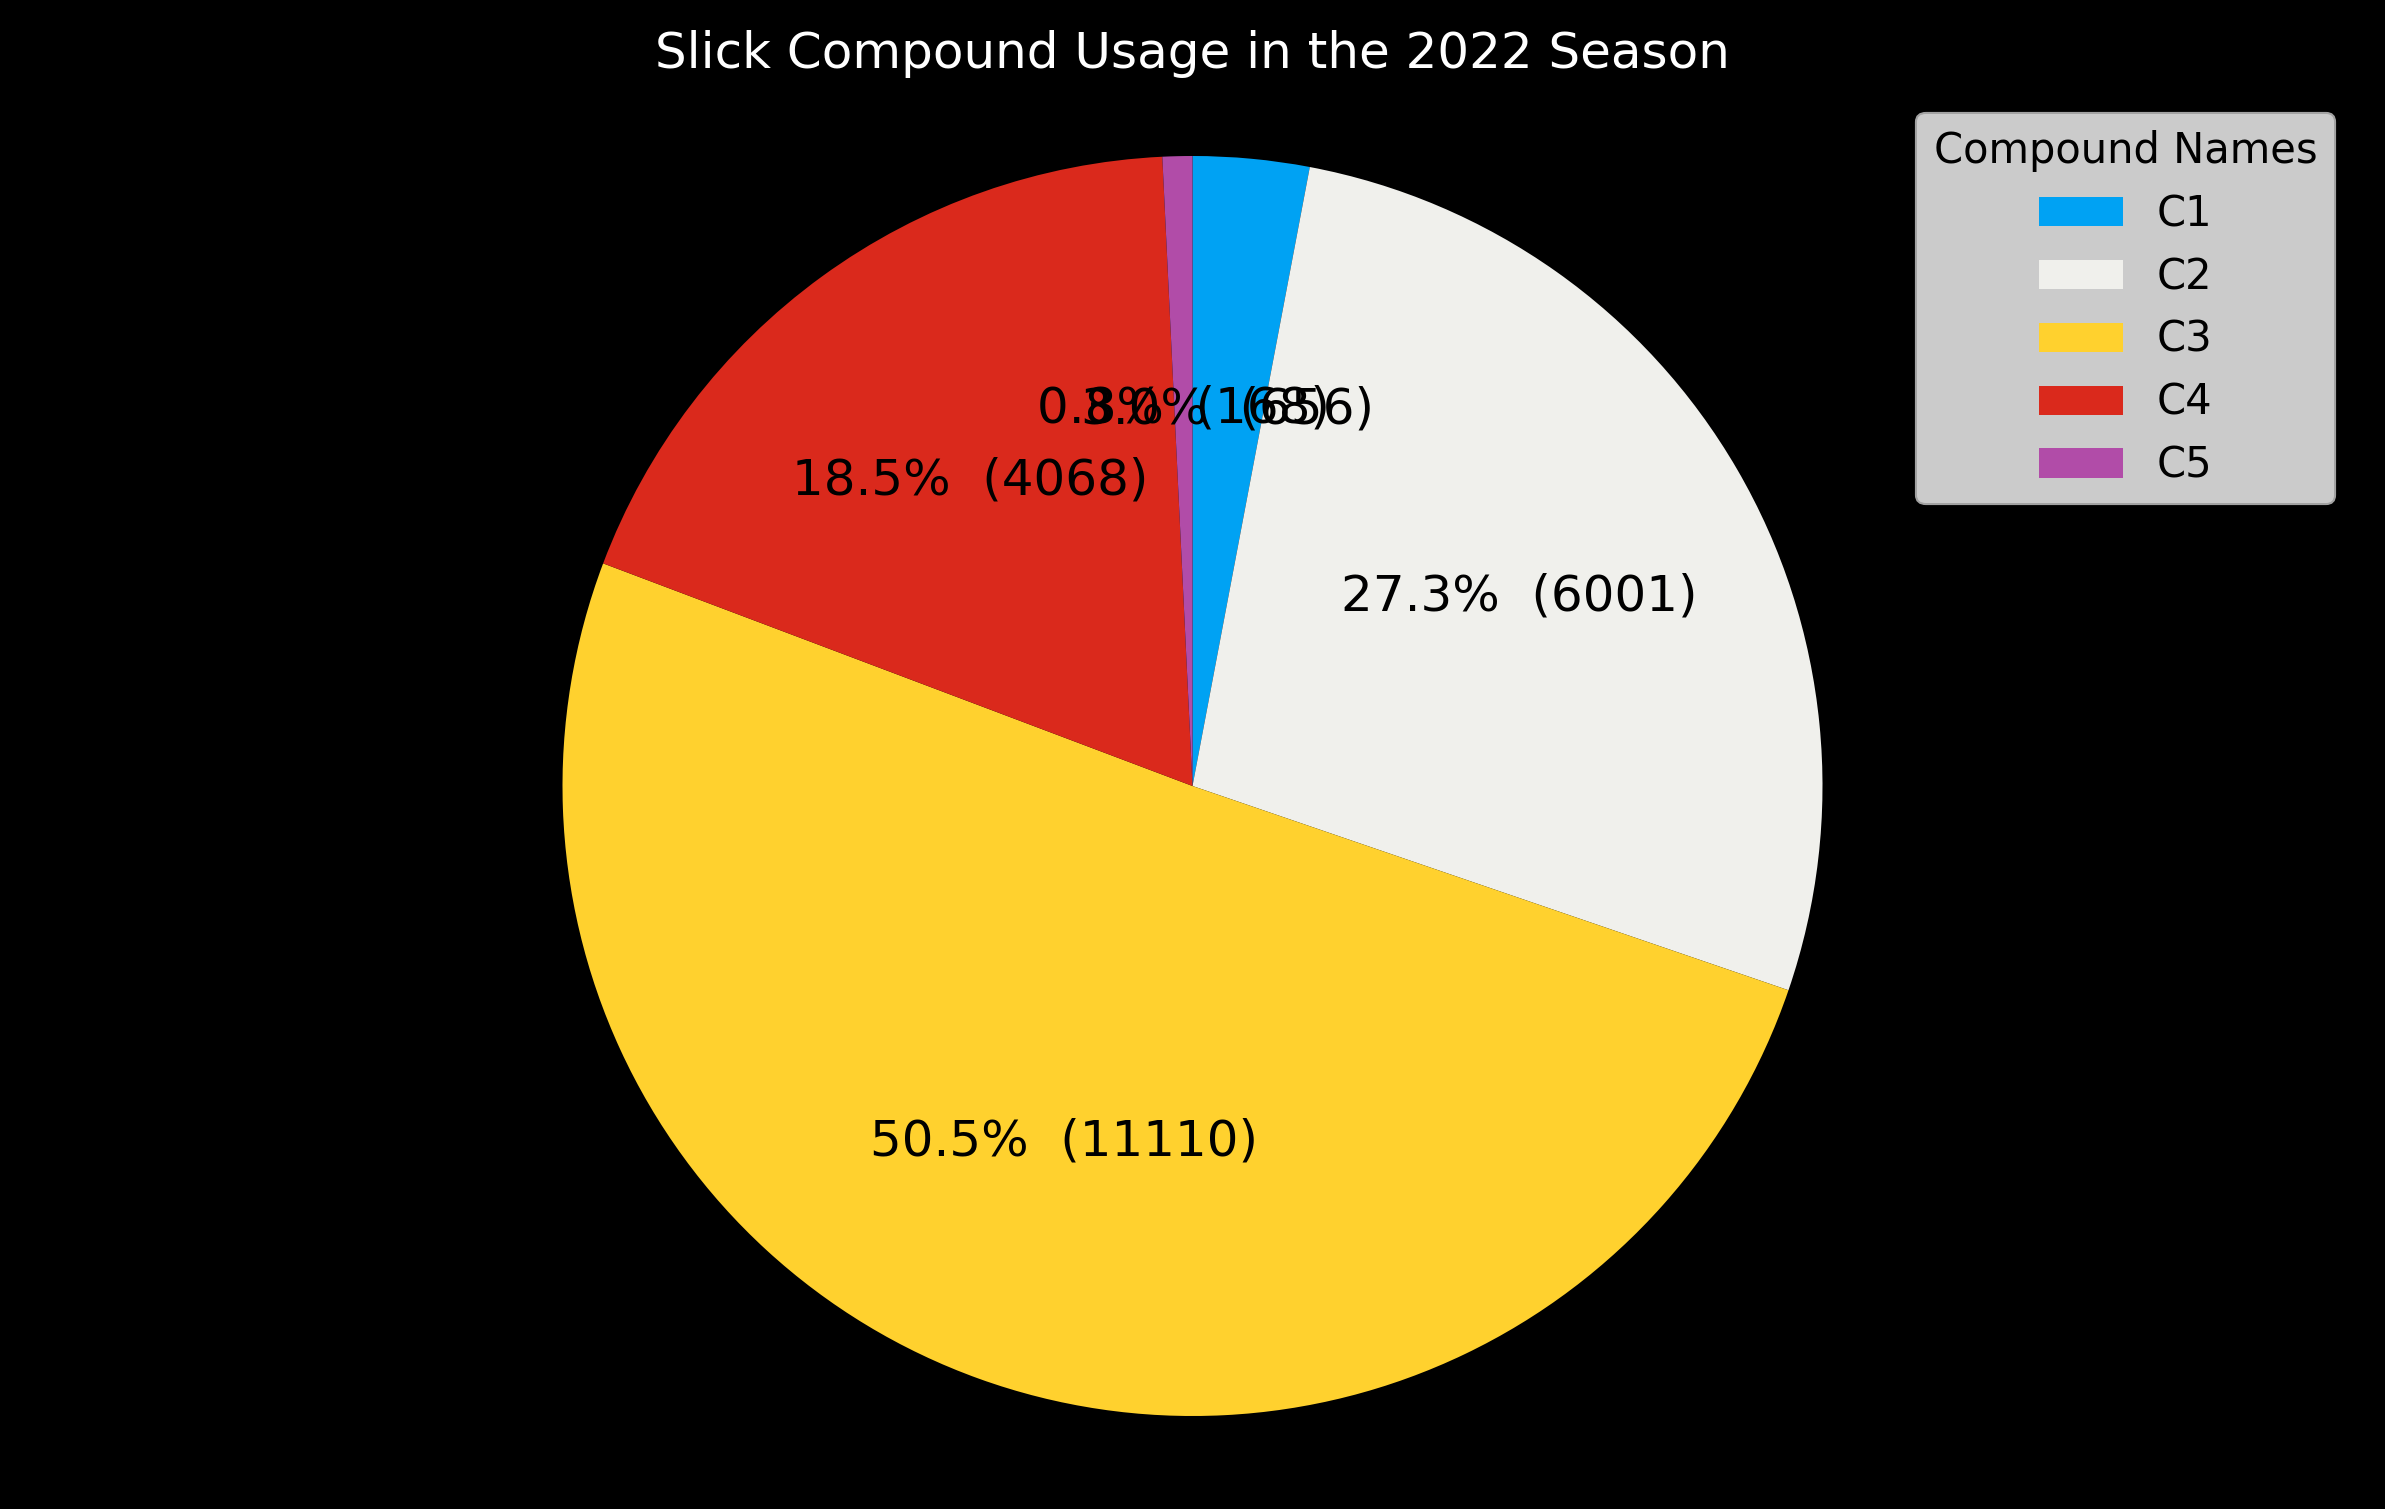

In [25]:
pie_chart = tyre_usage_pie(
    season=2022,
    title=None,
    events=None,
    drivers=None,
    slick_only=True,
    absolute_compound=True,
)

Visualize the lap times of the podium finishers in the 2019 British Grand Prix.

req         WARNING 	

DEFAULT CACHE ENABLED!
	Cache directory: C:\Users\guoca\AppData\Local\Temp\fastf1.
	Size: 321.89 KB
WARNING	req.py	

DEFAULT CACHE ENABLED!
	Cache directory: C:\Users\guoca\AppData\Local\Temp\fastf1.
	Size: 321.89 KB


core           INFO 	Loading data for British Grand Prix - Race [v3.0.4]
INFO	core.py	Loading data for British Grand Prix - Race [v3.0.4]
req            INFO 	Using cached data for driver_info
INFO	req.py	Using cached data for driver_info
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '16', '10', '33', '55', '3', '7', '26', '27', '4', '23', '18', '63', '88', '5', '11', '99', '8', '20']
INFO	core.py	Finished loading data for 20 drivers: ['44', '77', '16', '10', '33', '55', '3', '7', '26', '27', '4', '23', '18', '63', '88', '5', '11', '99', '8', '20']


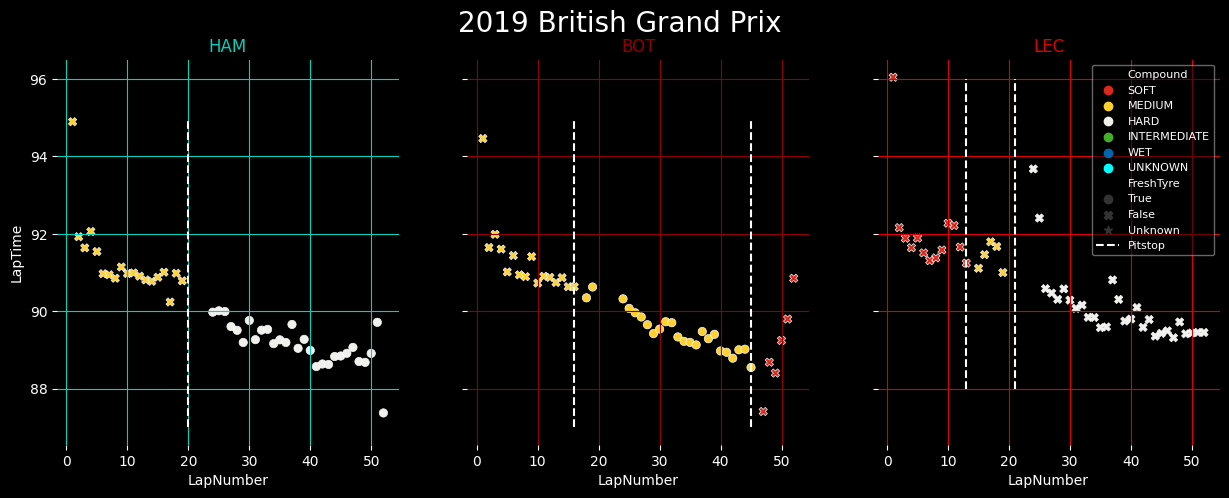

In [26]:
lap_time_plot = driver_stats_scatterplot(
    season=2019,
    event="Silverstone",
    drivers=3,
    y="LapTime",
    upper_bound=10,
    absolute_compound=False,
)

Visualize Hamilton's chasedown to Verstappan on a two-stop strategy during the 2021 Spanish Grand Prix.

core           INFO 	Loading data for Spanish Grand Prix - Race [v3.0.4]
INFO	core.py	Loading data for Spanish Grand Prix - Race [v3.0.4]
req            INFO 	Using cached data for driver_info
INFO	req.py	Using cached data for driver_info
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '16', '11', '3', '55', '4', '31', '10', '18', '7', '5', '63', '99', '6', '14', '47', '9', '22']
INFO	core.py	Finished loading data for 20 drivers: ['44', '33', '77', '16', '11', '3', '55', '4', '31', '10', '18', '7', '5', '63', '99', '6', '14', '47', '9', '22']


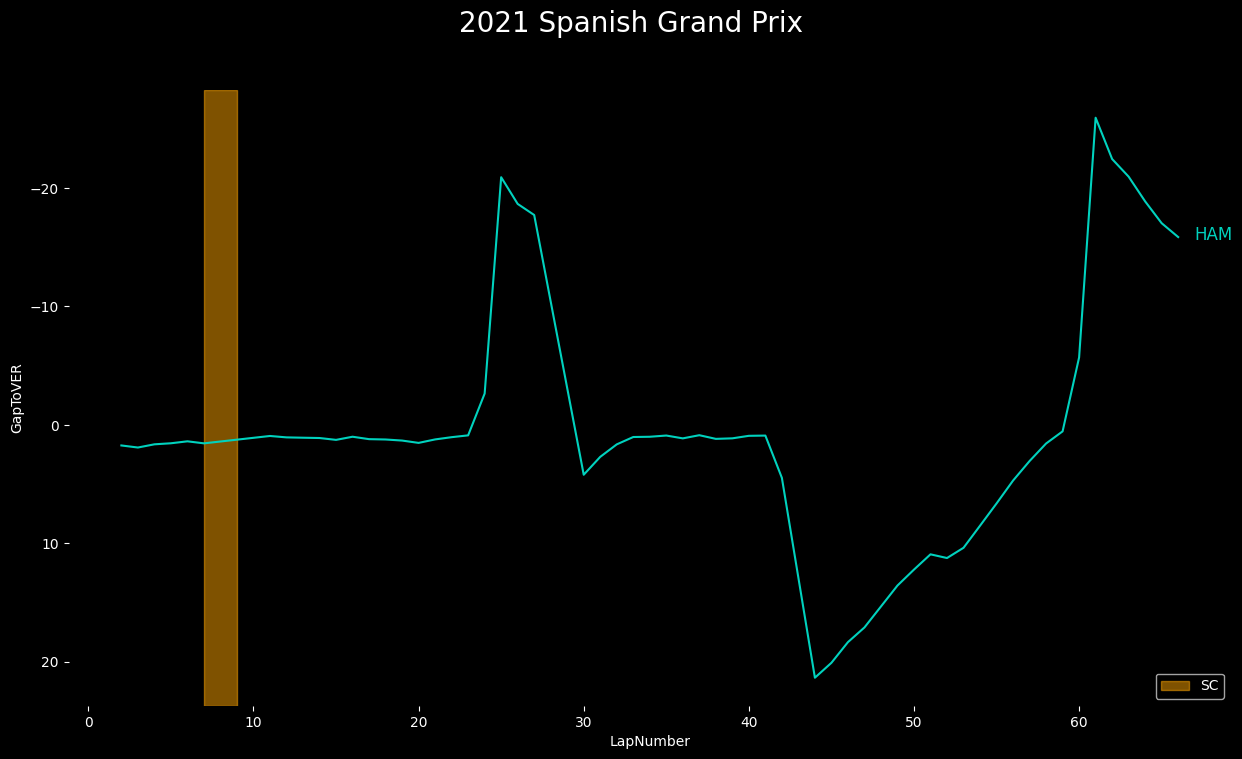

In [27]:
add_gap(2021, "VER")
gap_plot = driver_stats_lineplot(
    season=2021, event="Spin", drivers=["HAM"], y="GapToVER"
)

Visualize the lap time distributions of point finishers in the 2023 Bahrain Grand Prix

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.0.4]
INFO	core.py	Loading data for Bahrain Grand Prix - Race [v3.0.4]
req            INFO 	Using cached data for driver_info
INFO	req.py	Using cached data for driver_info
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']
INFO	core.py	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']


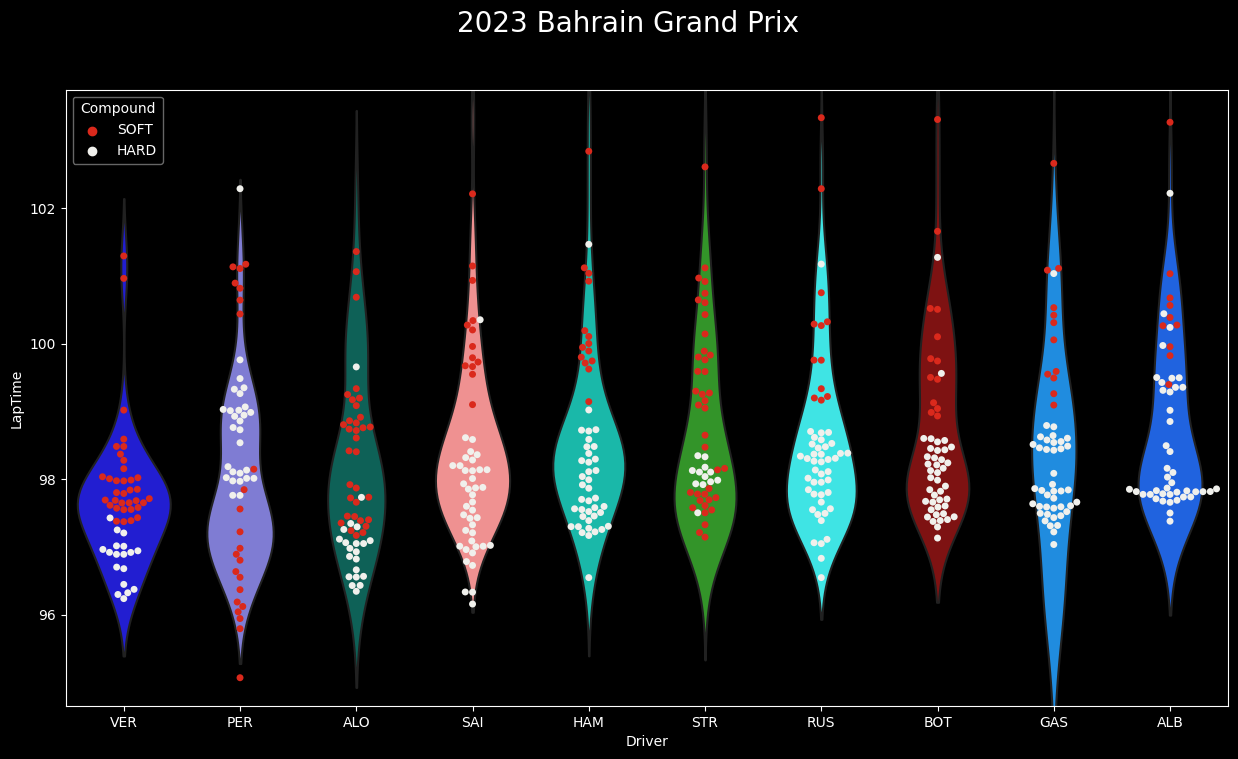

In [28]:
stats_distplot = driver_stats_distplot(2023, 1)

Compare the performance of teammates in the 2023 British Grand Prix

core           INFO 	Loading data for British Grand Prix - Race [v3.0.4]
INFO	core.py	Loading data for British Grand Prix - Race [v3.0.4]
req            INFO 	Using cached data for driver_info
INFO	req.py	Using cached data for driver_info
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '44', '81', '63', '11', '14', '23', '16', '55', '2', '77', '27', '18', '24', '22', '21', '10', '20', '31']
INFO	core.py	Finished loading data for 20 drivers: ['1', '4', '44', '81', '63', '11', '14', '23', '16', '55', '2', '77', '27', '18', '24', '22', '21', '10', '20', '31']


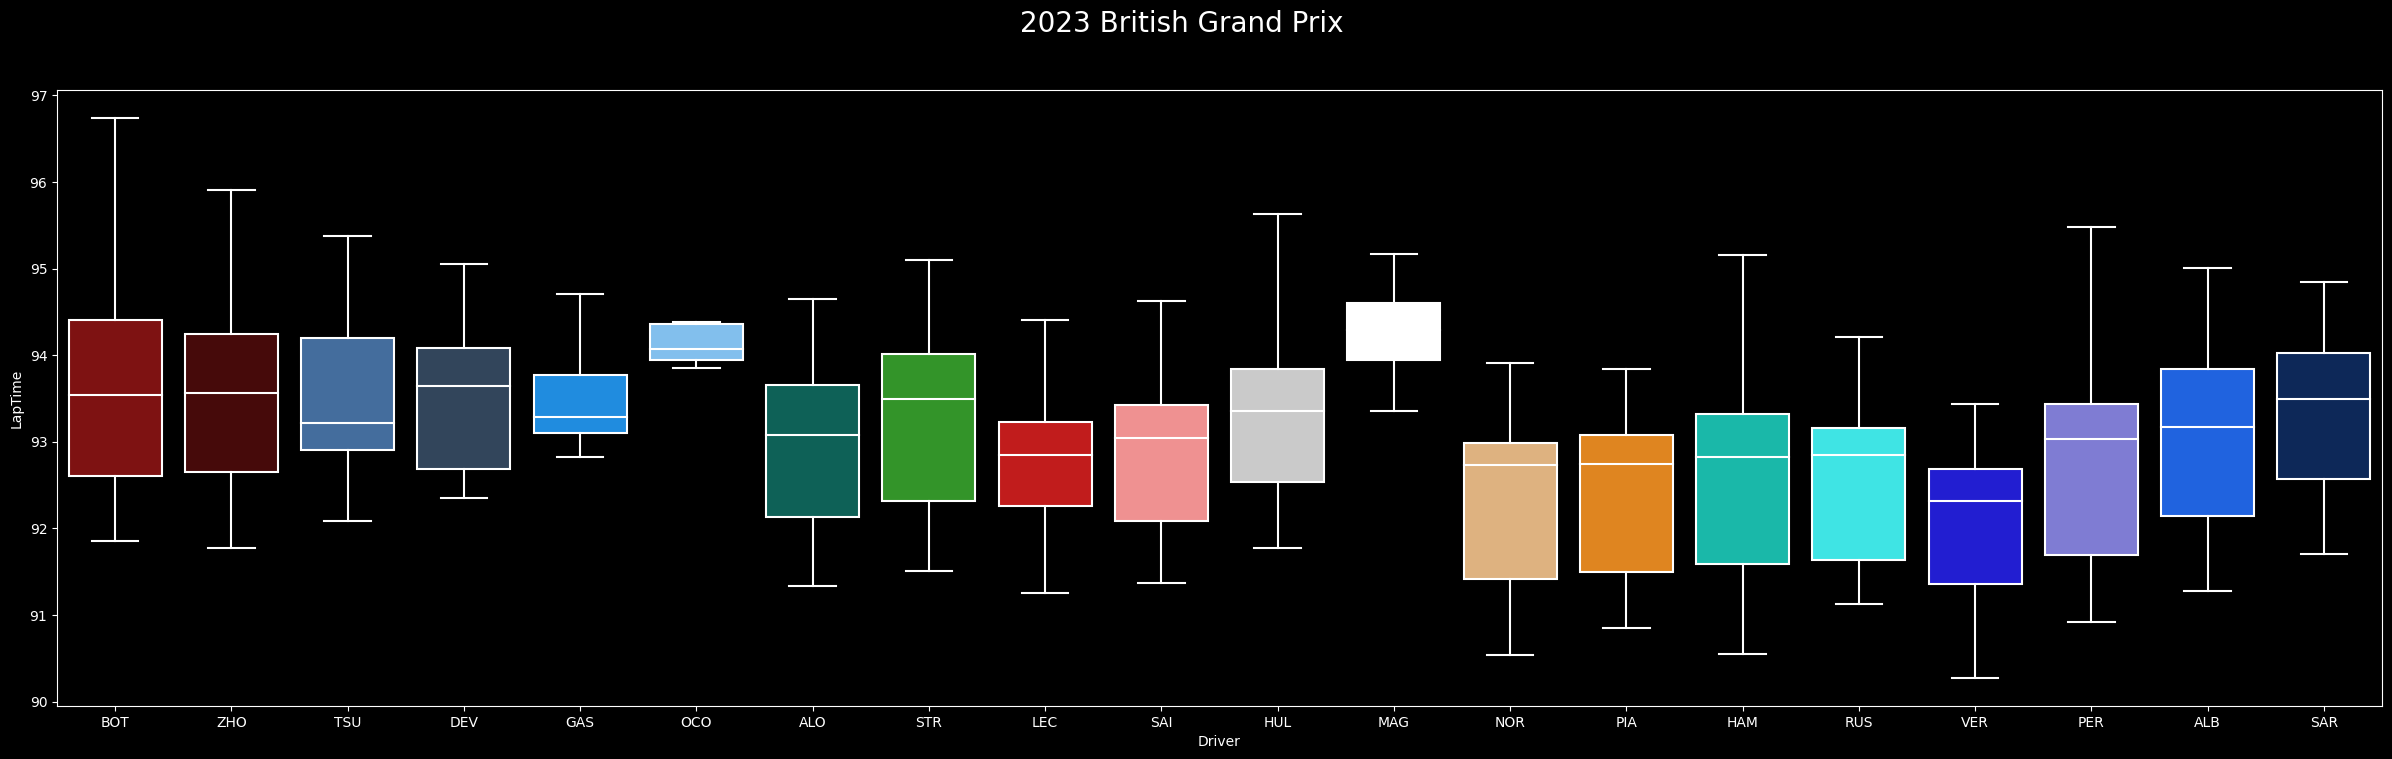

In [29]:
teammate_comp = driver_stats_distplot(
    2023, 10, drivers=20, swarm=False, violin=False, teammate_comp=True
)

Visualize Sainz's recovery drive (14 places gained) in the 2022 Italian Grand Prix.

core           INFO 	Loading data for Italian Grand Prix - Race [v3.0.4]
INFO	core.py	Loading data for Italian Grand Prix - Race [v3.0.4]
req            INFO 	Using cached data for driver_info
INFO	req.py	Using cached data for driver_info
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '55', '44', '11', '4', '10', '45', '24', '31', '47', '77', '22', '6', '20', '3', '18', '14', '5']
INFO	core.py	Finished loading data for 20 drivers: ['1', '16', '63', '55', '44', '11', '4', '10', '45', '24', '31', '47', '77', '22', '6', '20', '3', '18', '14', '5']


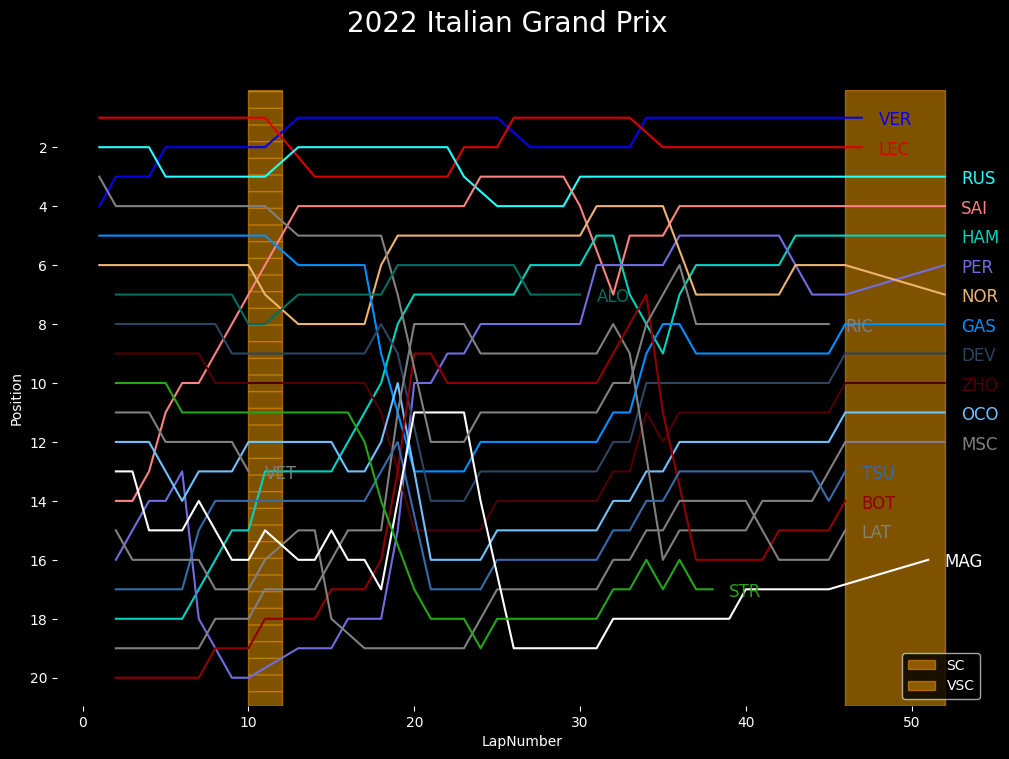

In [30]:
position_plot = driver_stats_lineplot(
    season=2022, event="Monza", drivers=20, y="Position"
)

Visualize the strategies of the top 10 driver use in the 2020 Austrian Grand Prix.


DEBUG	utils.py	Failed to parse datetime string ''
Traceback (most recent call last):
  File "d:\Projects\F1-Visualization\.venv\Lib\site-packages\fastf1\utils.py", line 198, in to_datetime
    date, time = x.strip('Z').split('T')
    ^^^^^^^^^^
ValueError: not enough values to unpack (expected 2, got 1)
DEBUG	utils.py	Failed to parse datetime string ''
Traceback (most recent call last):
  File "d:\Projects\F1-Visualization\.venv\Lib\site-packages\fastf1\utils.py", line 198, in to_datetime
    date, time = x.strip('Z').split('T')
    ^^^^^^^^^^
ValueError: not enough values to unpack (expected 2, got 1)
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.0.4]
INFO	core.py	Loading data for Austrian Grand Prix - Race [v3.0.4]
req            INFO 	Using cached data for driver_info
INFO	req.py	Using cached data for driver_info
core           INFO 	Finished loading data for 20 drivers: ['77', '16', '4', '44', '55', '11', '10', '31', '99', '5', '6', '26', '23', '7', '63', '8'

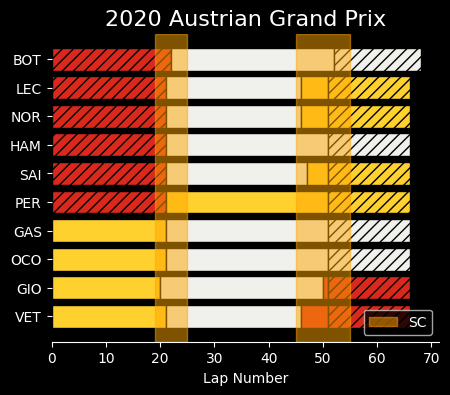

In [31]:
strategy_plot = strategy_barplot(
    season=2020, event="Austria", drivers=10, absolute_compound=False
)

Visualize tyre degradation by compound at the 2022 Hungary Grand Prix.

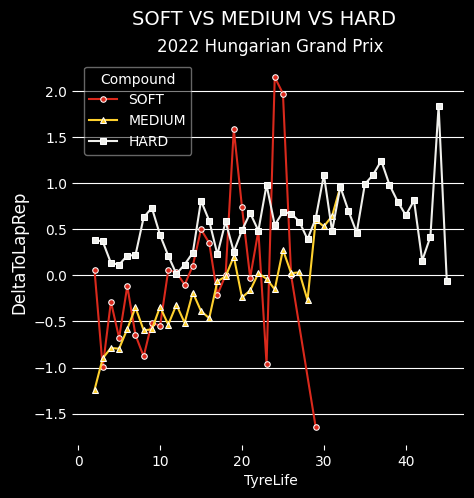

In [32]:
tyre_lineplot = compounds_lineplot(
    seasons=[2022],
    events=["Hungary"],
    y="DeltaToLapRep",
    compounds=["SOFT", "MEDIUM", "HARD"],
    x="TyreLife",
    upper_bound=10,
    absolute_compound=False,
)

Visualize the performance difference between the medium and the hard compound in the 2022 Belgian Grand Prix.

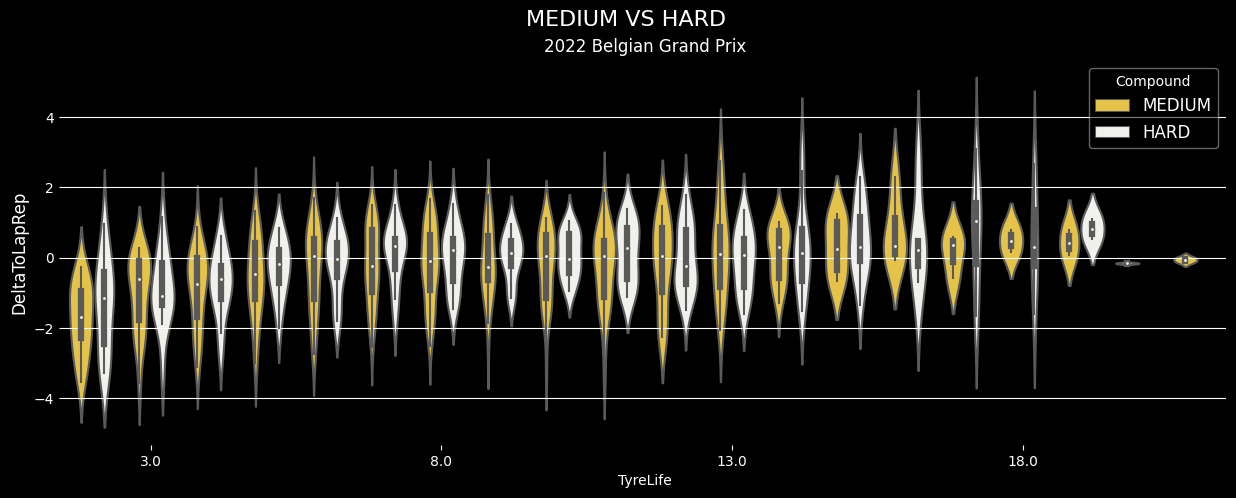

In [33]:
tyre_violinplot = compounds_distribution(
    seasons=[2022],
    events=["Belgium"],
    y="DeltaToLapRep",
    compounds=["HARD", "MEDIUM"],
    violin_plot=True,
    x="TyreLife",
    upper_bound=10,
    absolute_compound=False,
)

Visualize the crossover point between the two softest compounds in the 2018 Chinese Grand Prix?

WARNING	3105979029.py	ULTRASOFT is not plotted for 2018 Chinese Grand Prix because there is no valid lap time data


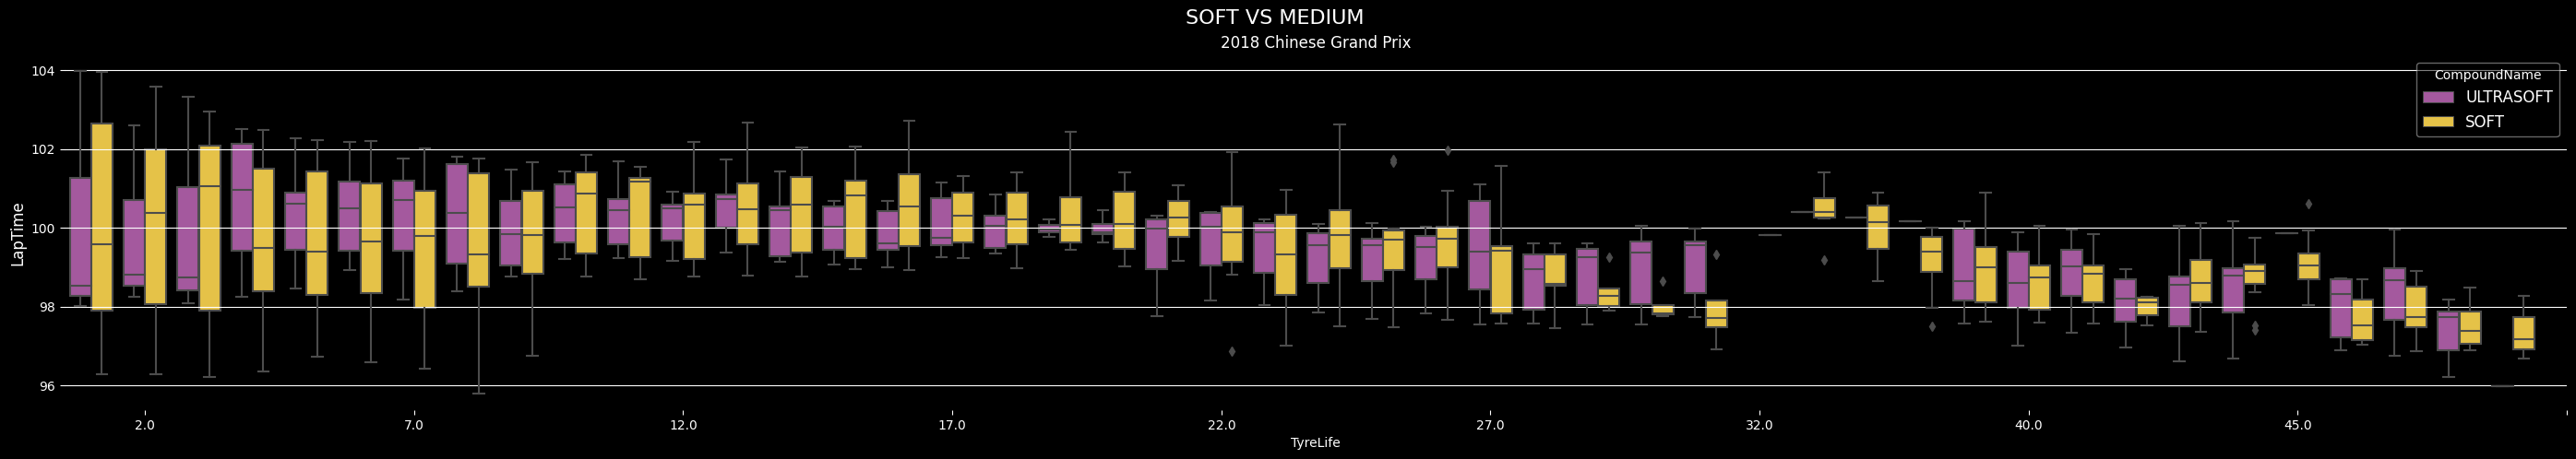

In [34]:
tyre_boxplot = compounds_distribution(
    seasons=[2018],
    events=["China"],
    y="LapTime",
    compounds=["SOFT", "MEDIUM"],
    violin_plot=False,
    x="TyreLife",
    upper_bound=10,
    absolute_compound=True,
)